# Plot a Spectral Signature

A spectral signature is a plot of the amount of light energy reflected by an object throughout the range of wavelengths in the electromagnetic spectrum. The spectral signature of an object conveys useful information about its structural and chemical composition. We can use these signatures to identify and classify different objects from a spectral image. 

For example, the atmosphere, soil, water, and vegetation have spectral signatures of distinctly different shapes, as illustrated in the following figure:
<p>
<center><strong>Example Spectral Signatures of Atmosphere, Soil, Water, and Vegetation</strong></center>
<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/spectralSignatures_MoleroGarzo.png" style="width: 400px;"/>
<center><font size="2">Figure: <a href="http://remotesensing.spiedigitallibrary.org/article.aspx?articleid=1352329" target="_blank">Molero and Garzón, 2012</a></font></center>
<center><font size="2"></font></center>
</p>
Vegetation has a unique spectral signature characterized by high reflectance in the near infrared wavelengths, and much lower reflectance in the green portion of the visible spectrum. We can extract reflectance values in the NIR and visible spectrums from hyperspectral data in order to map vegetation on the earth's surface. We will explore this more in Lesson 4, where we will caluclate a Vegetation Index.  
<p><center><strong>Vegetation Spectrum<strong></center>
<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/vegetationSpectrum_MarkElowitz.png" style="width: 600px;"/>
<center><font size="2">Figure: Mark Elowitz, retrieved December 22, 2016</font></center>
<center><font size="2"></font></center>
<p>

## Objectives

In this exercise, we will learn how to extract and plot a spectral profile from a single pixel of a reflectance band in a NEON hyperspectral hdf5 file. To do this, we will use the **extract_band** function that we generated in Lesson 2, and the Python package **pandas** to create a dataframe for the reflectance and associated wavelength data. 

In [15]:
#Import required packages
import h5py
import numpy as np
import pandas as pd
import gdal
import matplotlib.pyplot as plt
import IPython.display 
from PIL import Image

#Set display Preferences
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore') #don't display warnings

In [ ]:
# In order to load the required functions from 
# the included .py file, first navigate to the directory
# that contains the functions definition file
#import os
#os.chdir("/Users/olearyd/Git/data/")
#%load neon_aop_refl_hdf5_functions

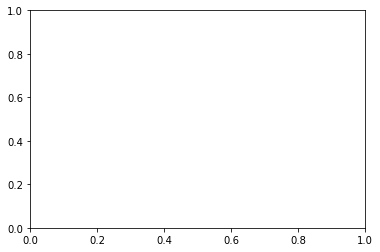

In [16]:
# %load neon_aop_refl_hdf5_functions
"""
Created on Mon Feb  6 16:36:10 2017

@author: bhass

neon_aop_refl_hdf5_functions contains the following functions for use in the 
Remote Sensing Data Institute (June 19-25, 2017)

list_dataset (called with h5py.File.visititems):
    lists the name and location of each dataset stored in an hdf5 file 

ls_dataset (called with h5py.File.visititems):
    lists name, shape, and type of each dataset stored in an hdf5 file

h5refl2array(refl_filename): 
    reads in a NEON AOP reflectance hdf5 file and returns reflectance array, 
    select metadata, and wavelength dataset

extract_raw_band(reflArray,reflArray_metadata,band_ind):
    extracts a single band from a reflectance array without applying the scale 
    factor or data ignore value

clean_band(bandArray,reflArray_metadata):
    sets the data ignore value to NaN and applies the scale factor to a single 
    reflectance band array

extract_clean_band(reflArray,reflArray_metadata,band_ind):
    extracts a single band from a reflectance array, applies the scale factor 
    and sets the data ignore value to NaN

plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='', \
cmap_title='',colormap='spectral'):
    reads in and plots a single band of a reflectance array

array2raster(newRaster,reflBandArray,reflArray_metadata): 
    reads in a reflectance array and associated metadata and returns a geotif 
    raster named newRaster.tif

calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    calculates the indices relative to a full flight line extent of a subset 
    given a clip extent in UTM m (x,y)
    
subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    extracts a band from a reflectance array, subsets it to the specified 
    clipIndex, and applies the no data value and scale factor 

stack_clean_bands(reflArray,reflArray_metadata,bands):
    generates an array of three bands, and applies the data ignore value and 
    scale factor to each band
    
stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    subsets, cleans, and stacks specified bands from a reflectance array

"""

#Import Required Packages:
import numpy as np
import matplotlib.pyplot as plt
import h5py, gdal, osr, copy

def list_dataset(name,node):
    
    """list_dataset lists the name and location of each dataset stored in an 
    hdf5 file.
    --------
    See Also
    --------
    ls_dataset: 
        Lists name, shape, and type of each dataset stored in an hdf5 file.
    Example:
    --------
    f = h5py.File('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r') 
    f.visititems(list_dataset)"""
    
    if isinstance(node, h5py.Dataset):
        print(name)

def ls_dataset(name,node):
    
    """ls_dataset lists the name, shape, and datatype of each dataset stored in 
    an hdf5 file.
    --------
    See Also
    --------
    list_dataset: 
        Lists name and location of each dataset stored in an hdf5 file
    Example:
    --------
    f = h5py.File('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r') 
    f.visititems(ls_dataset)"""
    
    if isinstance(node, h5py.Dataset):
        print(node)

def h5refl2array(refl_filename):
    """h5refl2array reads in a NEON AOP reflectance hdf5 file and returns the
    reflectance array, select metadata, and wavelength dataset.
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            EPSG: coordinate reference system code (integer)
            *bad_band_window1: [1340 1445] range of wavelengths to ignore
            *bad_band_window2: [1790 1955] range of wavelengths to ignore 
            ext_dict: dictionary of spatial extent 
            extent: array of spatial extent (xMin, xMax, yMin, yMax)
            mapInfo: string of map information 
            *noDataVal: -9999.0
            projection: string of projection information
            *res: dictionary containing 'pixelWidth' and 'pixelHeight' values 
            *scaleFactor: 10000.0
            shape: tuple of reflectance shape (y, x, # of bands)
        * Asterixed values are the same for all NEON AOP hyperspectral 
        reflectance files processed 2016 & after.
    wavelengths:
        Wavelengths dataset. This is the same for all NEON AOP reflectance hdf5 files.
        wavelengths.value[n-1] gives the center wavelength for band n 
    --------
    This function applies to the NEON hdf5 format implemented in 2016, which 
    applies to data acquired in 2016 & 2017 as of June 2017. Data in earlier 
    NEON hdf5 format is will be re-processed after the 2017 flight season. 
    --------
    Example
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """
    
    #Read in reflectance hdf5 file 
    #include full or relative path if data is located in a different directory
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info'].value

    #Extract no data value & set no data value to NaN
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    
    #Extract bad band windows
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    mapInfo_string = str(mapInfo); 
    mapInfo_split = mapInfo_string.split(",")
    
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = float(mapInfo_split[5])
    metadata['res']['pixelHeight'] = float(mapInfo_split[6])
    
    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) #convert from string to floating point number
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions
    xMax = xMin + (refl_shape[1]*metadata['res']['pixelWidth']) #xMax = left edge + (# of columns * resolution)",
    yMin = yMax - (refl_shape[0]*metadata['res']['pixelHeight']) #yMin = top edge - (# of rows * resolution)",
    metadata['extent'] = (xMin,xMax,yMin,yMax) #useful format for plotting
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    
    return reflArray, metadata, wavelengths
    
def extract_raw_band(reflArray,reflArray_metadata,band_ind):
    
    """extract_raw_band extracts a single band from a reflectance array without 
    applying the scale factor or data ignore value.
     --------
    Parameters
    --------
        reflArray: array of reflectance values, created by h5refl2array function
        reflArray_metadata: reflectance metadata values, created by h5refl2array 
        band_ind: index of wavelength band to be extracted
    --------
    Returns 
    --------
        bandArray: array of single band, without scale factor or data ignore value applied. 
    --------
    See Also
    --------
    clean_band: 
        Applies the data ignore value and scale factor to a single band array of reflectance data.
    extract_clean_band:
        Extracts a single band of data from a reflectance array and applies the data ignore value and scale factor.
    Example:
    --------
    SERC_b56_raw = extract_raw_band(sercRefl,sercRefl_md,56) """
    
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    return bandArray 

def clean_band(bandArray,reflArray_metadata):
        
    """clean_band sets the data ignore value to NaN and applies the scale factor to a single reflectance band array.
     --------
    Parameters
    --------
        bandArray: array of single band of reflectance values, created from extract_raw_band function
        reflArray_metadata: reflectance metadata values, created from h5refl2array function
    --------
    Returns 
    --------
        band_clean: array of single band, with scale factor applied and data ignore value set to NaN.
    --------
    See Also
    --------
    extract_raw_band: 
        Extracts a single band from a reflectance array without applying the scale factor or data ignore value.
    extract_clean_band:
        Extracts a single band of data from a reflectance array and applies the data ignore value and scale factor.
    Example:
    --------
    SERC_b56_clean = clean_band(SERC_b56_raw,sercRefl_md) """
    
    band_clean = copy.copy(bandArray) #make a copy of the array so you don't change the value of the original bandArray
    band_clean[band_clean==int(reflArray_metadata['noDataVal'])]=np.nan
    band_clean = band_clean/reflArray_metadata['scaleFactor']
    return band_clean

def extract_clean_band(reflArray,reflArray_metadata,band_ind):
    
    """extract_clean_band extracts a single band from a reflectance array, applies the scale factor and sets the data ignore value to NaN.
    --------
    Parameters
    --------
        reflArray: array of reflectance values, created from h5refl2array function
        reflArray_metadata: reflectance metadata values, created from h5refl2array function
        band_ind: index of wavelength band to be extracted
    --------
    Returns 
    --------
        bandCleaned: array of single band, with scale factor applied and data ignore value set to NaN. 
    --------
    See Also
    --------
    extract_raw_band:
        Extracts a single band of data from a reflectance array and applies the data ignore value and scale factor.
    clean_band:
        Applies the scale factor and sets the data ignore value to NaN for a single reflectance band. 
    Example:
    --------
    SERC_b56_clean = extract_clean_band(sercRefl,sercRefl_md,56) """
    
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    bandCleaned = copy.copy(bandArray)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    return bandCleaned   

def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='spectral'):
    
    '''plot_band_array reads in and plots a single band of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
    --------
        plots flightline array of single band of reflectance data
    --------
    See Also
    --------
    plot_subset_band:
        plots a subset of a full flightline reflectance band array 
    Example:
    --------
    plot_band_array(SERC_b56_clean,sercRefl_md['extent'],(0,0.3),ax,title='SERC Band 56 Reflectance',cmap_title='Reflectance',colormap='spectral') ''' 
    
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

def array2raster(newRaster,reflBandArray,reflArray_metadata): 
    
    '''array2raster reads in a reflectance array and associated metadata and returns a geotif raster named newRaster.tif
    --------
    Parameters
    --------
        newRaster: string, name of new geotif raster created
        reflBandArray: reflectance array to be converted to raster
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
    --------
    Returns 
    --------
        newRaster.tif: geotif raster created from reflectance array and associated metadata
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    Example:
    --------
    array2raster('SERC_b56_clean.tif',SERC_b56_clean,sercRefl_md) ''' 
    
    cols = reflBandArray.shape[1]
    rows = reflBandArray.shape[0]
    pixelWidth = float(reflArray_metadata['res']['pixelWidth'])
    pixelHeight = -float(reflArray_metadata['res']['pixelHeight'])
    originX = reflArray_metadata['ext_dict']['xMin']
    originY = reflArray_metadata['ext_dict']['yMax']
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create('hopb_b56.tif', cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(reflBandArray)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(reflArray_metadata['epsg']) 
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    
    '''calc_clip_index calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    --------
    Parameters
    --------
        clipExtent: dictionary of extent of region 
        h5Extent: dictionary of extent of h5 file (from the h5refl2array function, this corresponds to metadata['ext_dict'])
        xscale: optional, pixel size in the x-dimension, default is 1m (applicable to NEON reflectance data)
        yscale: optional, pixel size in the y-dimension, default is 1m (applicable to NEON reflectance data)
    --------
    Returns 
    --------
        newRaster.tif: geotif raster created from reflectance array and associated metadata
    --------
    Notes
    --------
    The clipExtent must lie within the extent of the h5Extent for this function to work. 
    If clipExtent exceets h5Extent in any direction, the function will return an error message. 
    --------
    Example:
    --------
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    calc_clip_index(clipExtent, sercRefl, xscale=1, yscale=1) ''' 
    
    #Check to make sure clipExtent lies within h5Extent range
    if clipExtent['xMin'] < h5Extent['xMin'] or clipExtent['xMax'] > h5Extent['xMax'] \
    or clipExtent['yMin'] < h5Extent['yMin'] or clipExtent['yMax'] > h5Extent['yMax']:
        print('ERROR: clip extent exceeds full reflectance file extent.')
        return
    else:
        h5rows = h5Extent['yMax'] - h5Extent['yMin']
        h5cols = h5Extent['xMax'] - h5Extent['xMin']    

        ind_ext = {}
        ind_ext['xMin'] = round((clipExtent['xMin']-h5Extent['xMin'])/xscale)
        ind_ext['xMax'] = round((clipExtent['xMax']-h5Extent['xMin'])/xscale)
        ind_ext['yMax'] = round(h5rows - (clipExtent['yMin']-h5Extent['yMin'])/xscale)
        ind_ext['yMin'] = round(h5rows - (clipExtent['yMax']-h5Extent['yMin'])/yscale)
    
        return ind_ext

def subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    
    '''subset_clean_band extracts a band from a reflectance array, subsets it to the specified clipIndex, and applies the no data value and scale factor
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which multiple bands (typically 3) are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        clipIndex: ditionary; indices relative to a full flight line extent of a subset given a clip extent (generated by calc_clip_index function)
        bandIndex: band number to be extracted (integer between 1-426)
    --------
    Returns 
    --------
        bandCleaned: array of subsetted band with no data value set to NaN and scale factor applied
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    calc_clip_index:
        calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict']) 
    
    serc_b58_subset = sercRGBarray = subset_clean_band(sercRefl,sercRefl_md,serc_subInd,58) '''
    
    bandCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],bandIndex-1].astype(np.float)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    
    return bandCleaned 

def stack_clean_bands(reflArray,reflArray_metadata,bands):
        
    '''stack_clean_bands generates an array of three bands, and applies the data ignore value and scale factor to each band
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which three bands are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        bands: indices of bands to be stacked; bands must be between 0-426 (eg. bands=(60,30,20))
    --------
    Returns 
    --------
        stackedArray: array of stacked bands
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    RGBbands = (58,34,19)
    sercRGBarray = stack_clean_bands(sercRefl,sercRefl_md,RGBbands) ''' 
    
    band_clean_dict = {}
    band_clean_names = []

    stackedArray = np.zeros((reflArray.shape[0],reflArray.shape[1],len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = extract_clean_band(reflArray,reflArray_metadata,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

def stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    
    '''stack_subset_bands subsets, cleans, and stacks specified bands from a reflectance array
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which multiple bands (typically 3) are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        bands: indices of bands to be stacked; bands must be between 0-426 (eg. bands=(60,30,20))
        clipIndex: indices relative to a full flight line extent of a subset given a clip extent, (generated by calc_clip_index function)
    --------
    Returns 
    --------
        stackedArray: array of subsetted, stacked bands with no data value set to NaN and scale factor applied
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    calculcate_clip_index:
        calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    subset_clean_band:
        extracts, subsets, and cleans a single band from a reflectance array
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    RGBbands = (58,34,19)
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict']) 
    
    sercRGBarray = stack_subset_bands(sercRefl,sercRefl_md,RGBbands,serc_subInd) ''' 

    subArray_rows = clipIndex['yMax'] - clipIndex['yMin']
    subArray_cols = clipIndex['xMax'] - clipIndex['xMin']
    
    stackedArray = np.zeros((subArray_rows,subArray_cols,len(bands)),'uint8') #pre-allocate stackedArray matrix
    band_clean_dict = {}
    band_clean_names = []
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = subset_clean_band(reflArray,reflArray_metadata,clipIndex,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

In [17]:
sercRefl, sercRefl_md, wavelengths = h5refl2array('/Users/olearyd/Git/data/NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')

for item in sorted(sercRefl_md):
    print(item + ':',sercRefl_md[item])

bad_band_window1: [1340 1445]
bad_band_window2: [1790 1955]
epsg: 32618
ext_dict: {'xMin': 367167.0, 'xMax': 368273.0, 'yMin': 4300128.0, 'yMax': 4310980.0}
extent: (367167.0, 368273.0, 4300128.0, 4310980.0)
mapInfo: b'UTM, 1.000, 1.000, 367167.000, 4310980.000, 1.0000000000e+000, 1.0000000000e+000, 18, North, WGS-84, units=Meters'
noDataVal: -9999.0
projection: b'+proj=UTM +zone= 18 +ellps= WGS-84 +datum= WGS-84 +units= units=Meters +no_defs'
res: {'pixelWidth': 1.0, 'pixelHeight': 1.0}
scaleFactor: 10000.0
shape: (10852, 1106, 426)


In [18]:
# Subset and clean band
clipExtDict = {}
clipExtDict['xMin'] = 367400.
clipExtDict['xMax'] = 368100.
clipExtDict['yMin'] = 4305750.
clipExtDict['yMax'] = 4306350.

clipExtent = (clipExtDict['xMin'],clipExtDict['xMax'],clipExtDict['yMin'],clipExtDict['yMax'])

clipIndex = calc_clip_index(clipExtDict,sercRefl_md['ext_dict'])

serc_b56_subset = subset_clean_band(sercRefl,sercRefl_md,clipIndex,55)

#Print some statistics about the reflectance values
print('SERC Reflectance Subset Stats:')
print('min:',np.nanmin(serc_b56_subset))
print('max:',round(np.nanmax(serc_b56_subset),2))
print('mean:',round(np.nanmean(serc_b56_subset),2))

SERC Reflectance Subset Stats:
min: 0.0
max: 1.59
mean: 0.05


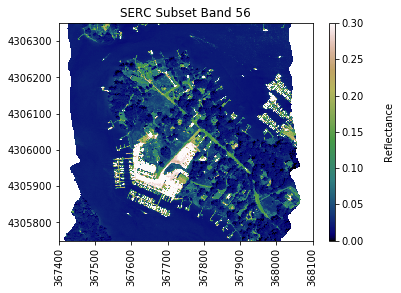

In [19]:
plot_band_array(serc_b56_subset,clipExtent,(0,0.3),title='SERC Subset Band 56',cmap_title='Reflectance',colormap='gist_earth')

We can use `pandas` to create a dataframe containing the wavelength and reflectance values for a single pixel - in this example, we'll look at pixel (5000,500). 

In [20]:
import pandas as pd
print('SERC subset shape:',sercRefl.shape)
serc_pixel_df = pd.DataFrame()
serc_pixel_df['reflectance'] = sercRefl[5000,500,:]/sercRefl_md['scaleFactor']
serc_pixel_df['wavelengths'] = wavelengths
print(serc_pixel_df.head(5))
print(serc_pixel_df.tail(5))
# np.max(serc_pixel_df['reflectance'])

SERC subset shape: (10852, 1106, 426)
   reflectance  wavelengths
0       0.0341     383.6579
1       0.0388     388.6656
2       0.0420     393.6733
3       0.0376     398.6810
4       0.0359     403.6888
     reflectance  wavelengths
421       0.5144    2491.9070
422       0.3699    2496.9147
423       0.2988    2501.9224
424       0.6360    2506.9301
425       1.4882    2511.9379


Now let's plot the spectra:

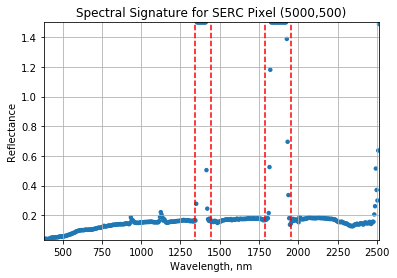

In [21]:
serc_pixel_df.plot(x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
plt.title('Spectral Signature for SERC Pixel (5000,500)')
ax = plt.gca() # ax = fig.add_subplot(1,2,1)
ax.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
ax.set_ylim([np.min(serc_pixel_df['reflectance']),np.max(serc_pixel_df['reflectance'])])
ax.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax.grid('on')

#Show bad band windows
plt.plot((1340,1340),(0,1.5), 'r--')
plt.plot((1445,1445),(0,1.5), 'r--')

plt.plot((1790,1790),(0,1.5), 'r--')
plt.plot((1955,1955),(0,1.5), 'r--')

##  Water Vapor Band Windows 
We can see from the spectral profile above that there are spikes in reflectance around ~1400nm and ~1800nm. These result from water vapor which absorbs light between wavelengths 1340-1445 nm and 1790-1955 nm. The atmospheric correction that converts radiance to reflectance subsequently results in a spike at these two bands. The wavelengths of these water vapor bands is stored in the reflectance attributes, which is saved in the reflectance metadata dictionary created with `h5refl2array`: 

In [22]:
bbw1 = sercRefl_md['bad_band_window1']; print('Bad Band Window 1:',bbw1)
bbw2 = sercRefl_md['bad_band_window2']; print('Bad Band Window 2:',bbw2)

Bad Band Window 1: [1340 1445]
Bad Band Window 2: [1790 1955]


We can now set these bad band windows, along with the last 10 bands, which are also often noisy (as seen in the spectral profile plotted above) to NaN:

In [23]:
import copy
w = copy.copy(wavelengths.value) #make a copy to deal with the mutable data type
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan #can also use bbw1[0] or bbw1[1] to avoid hard-coding in
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate
print(w)

[ 383.6579  388.6656  393.6733  398.681   403.6888  408.6965  413.7042
  418.7119  423.7196  428.7274  433.7351  438.7428  443.7505  448.7582
  453.7659  458.7737  463.7814  468.7891  473.7968  478.8045  483.8122
  488.82    493.8277  498.8354  503.8431  508.8508  513.8586  518.8663
  523.874   528.8817  533.8894  538.8971  543.9049  548.9126  553.9203
  558.928   563.9357  568.9434  573.9512  578.9589  583.9666  588.9743
  593.982   598.9898  603.9975  609.0052  614.0129  619.0206  624.0283
  629.0361  634.0438  639.0515  644.0592  649.0669  654.0746  659.0824
  664.0901  669.0978  674.1055  679.1132  684.1209  689.1287  694.1364
  699.1441  704.1518  709.1595  714.1673  719.175   724.1827  729.1904
  734.1981  739.2058  744.2136  749.2213  754.229   759.2367  764.2444
  769.2521  774.2599  779.2676  784.2753  789.283   794.2907  799.2985
  804.3062  809.3139  814.3216  819.3293  824.337   829.3448  834.3525
  839.3602  844.3679  849.3756  854.3833  859.3911  864.3988  869.4065
  874.

(4300128.0, 4310980.0)

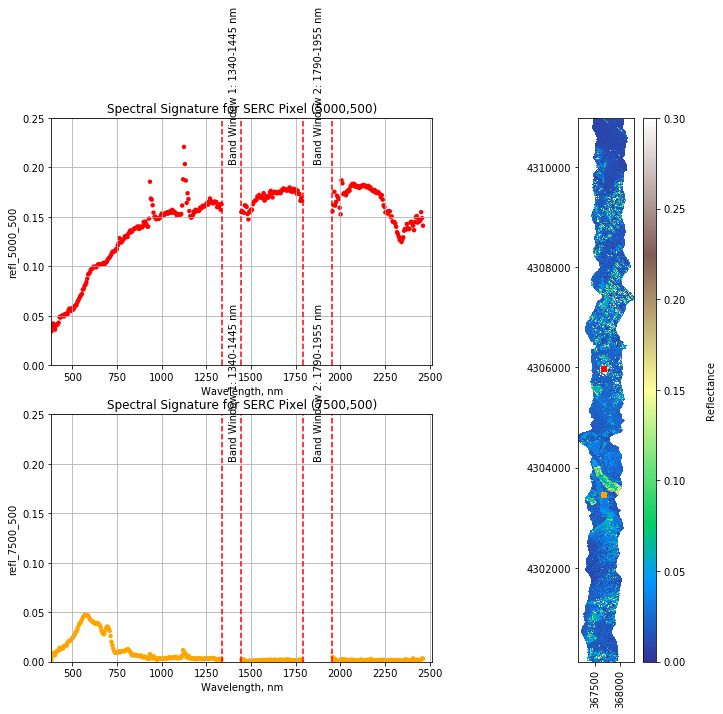

In [24]:
serc_pixel_df = pd.DataFrame()
serc_pixel_df['refl_5000_500'] = sercRefl[5000,500,:]/sercRefl_md['scaleFactor']
serc_pixel_df['refl_7500_500'] = sercRefl[7500,500,:]/sercRefl_md['scaleFactor']
serc_pixel_df['wavelengths'] = w

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)

serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_5000_500',kind='scatter',color='red',edgecolor='none');
plt.title('Spectral Signature for SERC Pixel (5000,500)')
ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
ax.set_ylim([np.min(serc_pixel_df['refl_5000_500']),np.max(serc_pixel_df['refl_5000_500'])*1.2])
ax1.set_ylim(0,0.25)
ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax1.grid('on')

plt.plot((1340,1340),(0,1.5), 'r--')
plt.plot((1445,1445),(0,1.5), 'r--')
plt.plot((1790,1790),(0,1.5), 'r--')
plt.plot((1955,1955),(0,1.5), 'r--')

ax1.text(1375,0.205, 'Band Window 1: 1340-1445 nm', rotation='vertical')
ax1.text(1850,0.205, 'Band Window 2: 1790-1955 nm', rotation='vertical')

ax2 = fig.add_subplot(2,2,3)
serc_pixel_df.plot(ax=ax2,x='wavelengths',y='refl_7500_500',kind='scatter',color='orange',edgecolor='none');
plt.title('Spectral Signature for SERC Pixel (7500,500)')
ax2.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
ax.set_ylim([np.min(serc_pixel_df['refl_7500_500']),np.max(serc_pixel_df['refl_7500_500'])*1.2])
ax2.set_ylim(0,0.25)
ax2.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax2.grid('on')

plt.plot((1340,1340),(0,1.5), 'r--')
plt.plot((1445,1445),(0,1.5), 'r--')
plt.plot((1790,1790),(0,1.5), 'r--')
plt.plot((1955,1955),(0,1.5), 'r--')

ax2.text(1375,0.205, 'Band Window 1: 1340-1445 nm', rotation='vertical')
ax2.text(1850,0.205, 'Band Window 2: 1790-1955 nm', rotation='vertical')

# Plot RGB image of SERC flight line and location of pixel for reference:
# serc_rgbArray = stack_clean_bands(sercRefl,sercRefl_md,(19,34,58))
# plot_band_array(serc_rgbArray,sercRefl_md['extent'],(0,100),ax=ax3,cbar='off')

# Plot band 56 for reference
ax3 = fig.add_subplot(1,4,3)
serc_b56 = extract_clean_band(sercRefl,sercRefl_md,56)
plot_band_array(serc_b56,sercRefl_md['extent'],(0,0.3),ax=ax3,cmap_title='Reflectance',colormap='terrain')
ax3.plot(sercRefl_md['ext_dict']['xMin']+500,sercRefl_md['ext_dict']['yMax']-5000,
        's',markersize=5,color='red')

ax3.plot(sercRefl_md['ext_dict']['xMin']+500,sercRefl_md['ext_dict']['yMax']-7500,
        's',markersize=5,color='orange')

ax3.set_xlim(sercRefl_md['extent'][0],sercRefl_md['extent'][1])
ax3.set_ylim(sercRefl_md['extent'][2],sercRefl_md['extent'][3])

## Spectra of Pixel from Subset of Flight Line Reflectance Band

It will be easier to visualize the pixel if we zoom in on a subset of data. Let's take a look at the spectra of the subsetted area we explored in the previous lesson:

In [25]:
clipExtent = {}
clipExtent['xMin'] = 367400.
clipExtent['xMax'] = 368100.
clipExtent['yMin'] = 4305750.
clipExtent['yMax'] = 4306350.

clipExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
clipIndex = calc_clip_index(clipExtent,sercRefl_md['ext_dict'])

#Subset Reflectance to ClipExt
sercRefl_subset = subset_clean_refl(sercRefl,sercRefl_md,clipIndex)

#Subset Band 56
serc_b56_subset = subset_clean_band(sercRefl,sercRefl_md,clipIndex,56)

NameError: name 'subset_clean_refl' is not defined

In [ ]:
# Remove water vapor band windows and last 10 bands (containing noisy data)
w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate
nan_ind = np.argwhere(np.isnan(w))

serc_pixel_refl = sercRefl_subset[300,350,:]
serc_pixel_refl[nan_ind]=np.nan

In [ ]:
# Plot spectra and map with position of pixel:
pixel = (300,350)

w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate

serc_pixel_refl = sercRefl_subset[300,350,:]
serc_pixel_refl[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
serc_pixel_refl[-10:]=np.nan

serc_pixel_df = pd.DataFrame()
serc_pixel_df['reflectance'] = serc_pixel_refl
serc_pixel_df['wavelengths'] = w

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)

serc_pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
ax1.set_title('Spectra of Pixel ' + str(pixel))
ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); # ax2.set_ylim(0,0.25)
ax1.set_ylim([np.min(serc_pixel_df['reflectance']),np.max(serc_pixel_df['reflectance'])*1.2])
ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax1.grid('on'); 

ax2 = fig.add_subplot(1,2,2)
plot = plt.imshow(serc_b56_subset,extent=clipExt,clim=(0,0.1)); 
plt.title('SERC Subset Band 56'); 
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax2.plot(clipExtent['xMin']+300,clipExtent['yMin']+350,'s',markersize=5,color='red')
ax2.set_xlim(clipExt[0],clipExt[1])
ax2.set_ylim(clipExt[2],clipExt[3])

## Interactive Spectra Visualization

In [ ]:
refl_band = serc_b56_subset

w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
#use band window values from reflectance attributes 
# w[((w >= bw1[0]) & (w <= bw1[1])) | ((w >= bw2[0]) & (w <= bw2[1]))]=np.nan 
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate
nan_ind = np.argwhere(np.isnan(w))
# print(nan_ind.shape)

serc_pixel_refl = sercRefl_subset[300,350,:]
serc_pixel_refl[nan_ind]=np.nan

refl = copy.copy(sercRefl_subset)
print(refl.shape)

In [ ]:
from IPython.html.widgets import *

def spectraPlot(pixel_x,pixel_y):

    reflectance = refl[pixel_y,pixel_x,:]
    reflectance[nan_ind]=np.nan
    
    pixel_df = pd.DataFrame()
    pixel_df['reflectance'] = reflectance
    pixel_df['wavelengths'] = w

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)

    # fig, axes = plt.subplots(nrows=1, ncols=2)
    pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
    ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
    ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
    ax1.set_ylim([np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
    ax1.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
    ax1.grid('on')

    ax2 = fig.add_subplot(1,2,2)
    plot = plt.imshow(refl_band,extent=clipExt,clim=(0,0.1)); 
    plt.title('Pixel Location'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
    ax2.plot(clipExtent['xMin']+pixel_x,clipExtent['yMax']-pixel_y,'s',markersize=5,color='red')
    ax2.set_xlim(clipExt[0],clipExt[1])
    ax2.set_ylim(clipExt[2],clipExt[3])
    
interact(spectraPlot, pixel_x = (0,refl.shape[1]-1,1),pixel_y=(0,refl.shape[0]-1,1))

## On Your Own: Explore the Data

Move around the pixel to different parts of the reflectance image. Look at the spectra of water, trees, grass, and concrete. What general patterns can you see?

In [ ]:
refl = copy.copy(sercRefl_subset)

w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate

nan_ind = np.argwhere(np.isnan(w))

refl_water = refl[350,100,:]; refl_water[nan_ind]=np.nan
refl_grass = refl[210,265,:]; refl_grass[nan_ind]=np.nan
refl_tree = refl[350,550,:]; refl_tree[nan_ind]=np.nan
refl_pavement = refl[350,350,:]; refl_pavement[nan_ind]=np.nan

serc_pixel_df = pd.DataFrame()
serc_pixel_df['refl_water'] = refl_water
serc_pixel_df['refl_grass'] = refl_grass
serc_pixel_df['refl_tree'] = refl_tree
serc_pixel_df['refl_pavement'] = refl_pavement
serc_pixel_df['wavelengths'] = w

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); plt.hold(True)

serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_water',label='water',legend=True,color='blue',edgecolor='none',kind='scatter');
serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_grass',color='lightgreen',edgecolor='none',kind='scatter',label='grass',legend=True);
serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_tree',color='darkgreen',edgecolor='none',kind='scatter',label='tree',legend=True);
serc_pixel_df.plot(ax=ax1,x='wavelengths',y='refl_pavement',color='gray',edgecolor='none',kind='scatter',label='pavement',legend=True);

ax1.set_title('Spectra of Pixel ' + str(pixel))
ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
ax1.set_ylim([np.min(serc_pixel_df['refl_grass']),np.max(serc_pixel_df['refl_grass'])*1.2])
ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")
ax1.grid('on'); 

ax2 = fig.add_subplot(1,2,2)
plot = plt.imshow(serc_b56_subset,extent=clipExt,clim=(0,0.1)); 
plt.title('SERC Subset Band 56'); plt.grid('on')
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

ax2.plot(clipExtent['xMin']+100,clipExtent['yMax']-350,'*',markersize=15,color='cyan') #water
ax2.plot(clipExtent['xMin']+265,clipExtent['yMax']-210,'*',markersize=15,color='lightgreen') #grass
ax2.plot(clipExtent['xMin']+550,clipExtent['yMax']-350,'*',markersize=15,color='darkgreen') #tree
ax2.plot(clipExtent['xMin']+350,clipExtent['yMax']-350,'*',markersize=15,color='gray') #pavement

ax2.set_xlim(clipExt[0],clipExt[1])
ax2.set_ylim(clipExt[2],clipExt[3])

## View Mean Spectra of Subset

In [ ]:
#Water
clipWaterExtDict = {}
clipWaterExtDict['xMin'] = 367900
clipWaterExtDict['xMax'] = 368000
clipWaterExtDict['yMin'] = 4306200
clipWaterExtDict['yMax'] = 4306300

clipWaterExtent = (clipWaterExtDict['xMin'],clipWaterExtDict['xMax'],clipWaterExtDict['yMin'],clipWaterExtDict['yMax'])
clipWaterIndex = calc_clip_index(clipWaterExtDict,sercRefl_md['ext_dict']); # print(clipWaterIndex)

reflWaterClip = subset_clean_refl(sercRefl,sercRefl_md,clipWaterIndex)

#Pavement
clipPavementExtDict = {}
clipPavementExtDict['xMin'] = 367610
clipPavementExtDict['xMax'] = 367660
clipPavementExtDict['yMin'] = 4305910
clipPavementExtDict['yMax'] = 4305960

clipPavementExtent = (clipPavementExtDict['xMin'],clipPavementExtDict['xMax'],clipPavementExtDict['yMin'],clipPavementExtDict['yMax'])
clipPavementIndex = calc_clip_index(clipPavementExtDict,sercRefl_md['ext_dict'])
# print(clipWaterIndex)

reflPavementClip = subset_clean_refl(sercRefl,sercRefl_md,clipPavementIndex)

#Grass
clipGrassExtDict = {}
clipGrassExtDict['xMin'] = 367630
clipGrassExtDict['xMax'] = 367680
clipGrassExtDict['yMin'] = 4306110
clipGrassExtDict['yMax'] = 4306160

clipGrassExtent = (clipGrassExtDict['xMin'],clipGrassExtDict['xMax'],clipGrassExtDict['yMin'],clipGrassExtDict['yMax'])
clipGrassIndex = calc_clip_index(clipGrassExtDict,sercRefl_md['ext_dict'])
# print(clipWaterIndex)

reflGrassClip = subset_clean_refl(sercRefl,sercRefl_md,clipGrassIndex)

In [ ]:
def plot_polygon(clipExtDict,ax=ax,color='white',annotation='off'):
    from matplotlib.path import Path
    import matplotlib.patches as patches
    
    verts = [
        (clipExtDict['xMin'],clipExtDict['yMin']), #lower left
        (clipExtDict['xMin'],clipExtDict['yMax']), #upper left
        (clipExtDict['xMax'],clipExtDict['yMax']), #upper right
        (clipExtDict['xMax'],clipExtDict['yMin']), #lower right
        (clipExtDict['xMin'],clipExtDict['yMin'])] #lower left - close polygon
    
    codes = [Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY]
    
    path = Path(verts,codes)
    patch = patches.PathPatch(path,edgecolor=color,facecolor='none',lw=2)
    ax.add_patch(patch)
    plt.grid(True); plt.rc('grid',color=color)
    if annotation == 'on':
        ax.annotate('Clipped Region', xy=(clipExtDict['xMax'],clipExtDict['yMax']),
                   xytext=(clipExtDict['xMax']+50,clipExtDict['yMax']+50),color=color,
                   arrowprops=dict(facecolor=color,frac=0.25,shrink=0.05))

In [ ]:
#Plot Mean Spectra of Subset Area

w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan; # print(w)

nan_ind = np.argwhere(np.isnan(w))

waterClipMeanRefl = reflWaterClip.mean(axis=(0,1))
waterClipMeanRefl[nan_ind]=np.nan

clipSpectra_df = pd.DataFrame()
clipSpectra_df['refl_water'] = waterClipMeanRefl
clipSpectra_df['refl_pavement'] = reflPavementClip.mean(axis=(0,1))
clipSpectra_df['refl_grass'] = reflGrassClip.mean(axis=(0,1))
clipSpectra_df['wavelengths'] = w

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); plt.hold(True)

clipSpectra_df.plot(ax=ax1,x='wavelengths',y='refl_water',label='water',legend=True,color='blue',edgecolor='none',kind='scatter')
clipSpectra_df.plot(ax=ax1,x='wavelengths',y='refl_pavement',label='pavement',legend=True,color='gray',edgecolor='none',kind='scatter')
clipSpectra_df.plot(ax=ax1,x='wavelengths',y='refl_grass',label='grass',legend=True,color='lightgreen',edgecolor='none',kind='scatter')

ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); # ax2.set_ylim(0,0.25)
ax1.set_ylim([0,0.5]); plt.grid('on')
ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")
ax1.set_title('Mean Spectra of Clipped Regions')

#Plot Polygons of Clipped Regions on Map
ax2 = fig.add_subplot(1,2,2); plt.hold(True)
plot = plt.imshow(serc_b56_subset,extent=clipExt,clim=(0,0.1)); 
plt.title('SERC Subset Band 56 \n Locations of Clipped Regions'); plt.grid('on')
cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
cbar.set_label('Reflectance',rotation=90,labelpad=20); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.hold('on'); plt.grid('on')

plot_polygon(clipWaterExtDict,ax=ax2,color='blue')
plot_polygon(clipPavementExtDict,ax=ax2,color='gray')
plot_polygon(clipGrassExtDict,ax=ax2,color='lightgreen')

ax2.set_xlim(clipExt[0],clipExt[1])
ax2.set_ylim(clipExt[2],clipExt[3])

### References

Elowitz, Mark R. "What is Imaging Spectroscopy (Hyperspectral Imaging)?" http://www.markelowitz.com/Hyperspectral.html

Molero, José M. and Garzón, Ester M. Inmaculada García and Antonio Plaza "Anomaly detection based on a parallel kernel RX algorithm for multicore platforms", J. Appl. Remote Sens. 6(1), 061503 (May 10, 2012). ; http://dx.doi.org/10.1117/1.JRS.6.061503. 